# Method 3 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

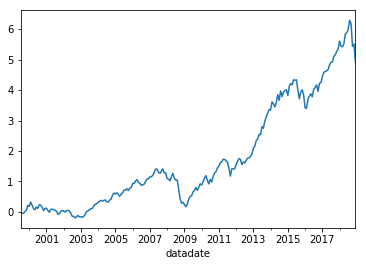

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.217319
2000-12-31   -0.087248
2001-12-31   -0.053034
2002-12-31   -0.203253
2003-12-31    0.516599
2004-12-31    0.275454
2005-12-31    0.112977
2006-12-31    0.155602
2007-12-31    0.095898
2008-12-31   -0.422724
2009-12-31    0.457984
2010-12-31    0.272081
2011-12-31   -0.012759
2012-12-31    0.199791
2013-12-31    0.505479
2014-12-31    0.147373
2015-12-31   -0.034244
2016-12-31    0.083081
2017-12-31    0.211033
2018-12-31   -0.067594
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     606.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-120
Time:                        12:55:06   Log-Likelihood:                 655.76
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1284.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.679      0.000       0.002       0.006
mktrf          0.9402      0.028     33.973      0.000       0.886       0.995
me             0.4313      0.032     13.399      0.000       0.368       0.495
ia            -0.1125      0.049     -2.298      0.022      -0.209      -0.016
roe           -0.0143      0.042     -0.342      0.733      -0.097       0.068
==============================================================================
Omnibus:                       20.899   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.731
Skew:                          -0.220   Prob(JB):                     1.19e-15
Kurtosis:                       5.618   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     543.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.22e-115
Time:                        12:55:06   Log-Likelihood:                 655.76
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1284.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.188      0.000       0.002       0.005
mktrf          0.9402      0.038     24.761      0.000       0.866       1.015
me             0.4313      0.034     12.510      0.000       0.364       0.499
ia            -0.1125      0.086     -1.305      0.192      -0.281       0.056
roe           -0.0143      0.061     -0.234      0.815      -0.135       0.106
==============================================================================
Omnibus:                       20.899   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.731
Skew:                          -0.220   Prob(JB):                     1.19e-15
Kurtosis:                       5.618   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     674.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.03e-125
Time:                        12:55:06   Log-Likelihood:                 655.76
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1284.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.889      0.000       0.002       0.006
mktrf          0.9402      0.029     31.906      0.000       0.882       0.998
me             0.4313      0.033     12.896      0.000       0.366       0.497
ia            -0.1125      0.087     -1.295      0.195      -0.283       0.058
roe           -0.0143      0.053     -0.269      0.788      -0.119       0.090
==============================================================================
Omnibus:                       20.899   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.731
Skew:                          -0.220   Prob(JB):                     1.19e-15
Kurtosis:                       5.618   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     444.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.32e-115
Time:                        12:55:06   Log-Likelihood:                 646.76
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     228   BIC:                            -1261.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.608      0.000       0.002       0.006
mktrf          0.9422      0.029     32.624      0.000       0.885       0.999
smb            0.4344      0.038     11.400      0.000       0.359       0.510
hml           -0.0983      0.045     -2.189      0.030      -0.187      -0.010
rmw           -0.0644      0.051     -1.268      0.206      -0.165       0.036
cma            0.0583      0.065      0.903      0.368      -0.069       0.186
==============================================================================
Omnibus:                        9.705   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               18.438
Skew:                          -0.119   Prob(JB):                     9.91e-05
Kurtosis:                       4.354   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     539.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.89e-124
Time:                        12:55:06   Log-Likelihood:                 646.76
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     228   BIC:                            -1261.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.595      0.000       0.002       0.006
mktrf          0.9422      0.038     24.736      0.000       0.868       1.017
smb            0.4344      0.042     10.226      0.000       0.351       0.518
hml           -0.0983      0.069     -1.416      0.157      -0.234       0.038
rmw           -0.0644      0.059     -1.087      0.277      -0.181       0.052
cma            0.0583      0.137      0.424      0.671      -0.211       0.328
==============================================================================
Omnibus:                        9.705   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               18.438
Skew:                          -0.119   Prob(JB):                     9.91e-05
Kurtosis:                       4.354   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     696.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.85e-136
Time:                        12:55:06   Log-Likelihood:                 646.76
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     228   BIC:                            -1261.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.344      0.001       0.002       0.006
mktrf          0.9422      0.038     25.117      0.000       0.869       1.016
smb            0.4344      0.040     10.748      0.000       0.355       0.514
hml           -0.0983      0.074     -1.333      0.183      -0.243       0.046
rmw           -0.0644      0.060     -1.069      0.285      -0.183       0.054
cma            0.0583      0.149      0.390      0.696      -0.234       0.351
==============================================================================
Omnibus:                        9.705   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               18.438
Skew:                          -0.119   Prob(JB):                     9.91e-05
Kurtosis:                       4.354   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     581.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-118
Time:                        12:55:06   Log-Likelihood:                 651.27
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.068      0.002       0.001       0.005
mktrf          1.0061      0.026     38.734      0.000       0.955       1.057
smb            0.3961      0.032     12.217      0.000       0.332       0.460
hml            0.0138      0.032      0.429      0.669      -0.050       0.077
umd            0.0994      0.021      4.705      0.000       0.058       0.141
==============================================================================
Omnibus:                        9.976   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.136
Skew:                          -0.077   Prob(JB):                     4.24e-05
Kurtosis:                       4.429   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     607.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.37e-120
Time:                        12:55:06   Log-Likelihood:                 651.27
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.874      0.004       0.001       0.005
mktrf          1.0061      0.034     29.694      0.000       0.940       1.072
smb            0.3961      0.038     10.309      0.000       0.321       0.471
hml            0.0138      0.056      0.245      0.806      -0.097       0.124
umd            0.0994      0.039      2.562      0.010       0.023       0.175
==============================================================================
Omnibus:                        9.976   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.136
Skew:                          -0.077   Prob(JB):                     4.24e-05
Kurtosis:                       4.429   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     821.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.75e-134
Time:                        12:55:06   Log-Likelihood:                 651.27
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     229   BIC:                            -1275.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.820      0.005       0.001       0.005
mktrf          1.0061      0.029     34.888      0.000       0.950       1.063
smb            0.3961      0.035     11.411      0.000       0.328       0.464
hml            0.0138      0.057      0.240      0.810      -0.099       0.126
umd            0.0994      0.038      2.626      0.009       0.025       0.174
==============================================================================
Omnibus:                        9.976   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.136
Skew:                          -0.077   Prob(JB):                     4.24e-05
Kurtosis:                       4.429   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     248.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-55
Time:                        12:55:06   Log-Likelihood:                 310.87
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.219      0.028       0.000       0.007
mktrf          0.9726      0.048     20.360      0.000       0.878       1.067
me             0.4393      0.047      9.311      0.000       0.346       0.533
ia            -0.0868      0.074     -1.175      0.243      -0.233       0.060
roe            0.0439      0.065      0.671      0.504      -0.086       0.173
==============================================================================
Omnibus:                       10.095   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.944
Skew:                          -0.316   Prob(JB):                     0.000127
Kurtosis:                       4.786   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     251.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.55e-56
Time:                        12:55:06   Log-Likelihood:                 310.87
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.345      0.001       0.002       0.006
mktrf          0.9726      0.069     14.021      0.000       0.837       1.109
me             0.4393      0.045      9.724      0.000       0.351       0.528
ia            -0.0868      0.104     -0.837      0.402      -0.290       0.116
roe            0.0439      0.088      0.499      0.618      -0.128       0.216
==============================================================================
Omnibus:                       10.095   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.944
Skew:                          -0.316   Prob(JB):                     0.000127
Kurtosis:                       4.786   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     329.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.50e-62
Time:                        12:55:06   Log-Likelihood:                 310.87
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.464      0.001       0.002       0.006
mktrf          0.9726      0.051     19.249      0.000       0.874       1.072
me             0.4393      0.046      9.621      0.000       0.350       0.529
ia            -0.0868      0.102     -0.855      0.393      -0.286       0.112
roe            0.0439      0.067      0.653      0.514      -0.088       0.176
==============================================================================
Omnibus:                       10.095   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.944
Skew:                          -0.316   Prob(JB):                     0.000127
Kurtosis:                       4.786   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     182.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-52
Time:                        12:55:06   Log-Likelihood:                 306.61
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      2.568      0.012       0.001       0.009
mktrf          0.9846      0.052     18.783      0.000       0.881       1.088
smb            0.4452      0.059      7.499      0.000       0.328       0.563
hml           -0.1507      0.073     -2.071      0.041      -0.295      -0.007
rmw            0.0035      0.086      0.041      0.968      -0.166       0.173
cma            0.1407      0.094      1.497      0.137      -0.045       0.327
==============================================================================
Omnibus:                        2.455   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.901
Skew:                          -0.259   Prob(JB):                        0.386
Kurtosis:                       3.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     317.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.44e-65
Time:                        12:55:06   Log-Likelihood:                 306.61
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      3.177      0.001       0.002       0.008
mktrf          0.9846      0.074     13.370      0.000       0.840       1.129
smb            0.4452      0.063      7.098      0.000       0.322       0.568
hml           -0.1507      0.107     -1.414      0.157      -0.360       0.058
rmw            0.0035      0.112      0.031      0.975      -0.217       0.224
cma            0.1407      0.173      0.814      0.415      -0.198       0.479
==============================================================================
Omnibus:                        2.455   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.901
Skew:                          -0.259   Prob(JB):                        0.386
Kurtosis:                       3.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     340.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.50e-67
Time:                        12:55:06   Log-Likelihood:                 306.61
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      3.152      0.002       0.002       0.008
mktrf          0.9846      0.074     13.278      0.000       0.839       1.130
smb            0.4452      0.062      7.146      0.000       0.323       0.567
hml           -0.1507      0.117     -1.290      0.197      -0.380       0.078
rmw            0.0035      0.123      0.028      0.977      -0.238       0.245
cma            0.1407      0.183      0.768      0.442      -0.218       0.500
==============================================================================
Omnibus:                        2.455   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.901
Skew:                          -0.259   Prob(JB):                        0.386
Kurtosis:                       3.336   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     249.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-55
Time:                        12:55:06   Log-Likelihood:                 311.04
No. Observations:                 120   AIC:                            -612.1
Df Residuals:                     115   BIC:                            -598.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      2.843      0.005       0.001       0.008
mktrf          1.0489      0.042     24.962      0.000       0.966       1.132
smb            0.3648      0.048      7.626      0.000       0.270       0.460
hml            0.0212      0.048      0.442      0.659      -0.074       0.116
umd            0.1234      0.030      4.175      0.000       0.065       0.182
==============================================================================
Omnibus:                        7.153   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.269
Skew:                          -0.311   Prob(JB):                      0.00971
Kurtosis:                       4.212   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     453.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-69
Time:                        12:55:06   Log-Likelihood:                 311.04
No. Observations:                 120   AIC:                            -612.1
Df Residuals:                     115   BIC:                            -598.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      3.373      0.001       0.002       0.008
mktrf          1.0489      0.052     20.225      0.000       0.947       1.151
smb            0.3648      0.051      7.164      0.000       0.265       0.465
hml            0.0212      0.069      0.307      0.759      -0.114       0.157
umd            0.1234      0.045      2.724      0.006       0.035       0.212
==============================================================================
Omnibus:                        7.153   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.269
Skew:                          -0.311   Prob(JB):                      0.00971
Kurtosis:                       4.212   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     673.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.59e-79
Time:                        12:55:06   Log-Likelihood:                 311.04
No. Observations:                 120   AIC:                            -612.1
Df Residuals:                     115   BIC:                            -598.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      3.949      0.000       0.002       0.007
mktrf          1.0489      0.038     27.720      0.000       0.975       1.123
smb            0.3648      0.041      8.925      0.000       0.285       0.445
hml            0.0212      0.070      0.302      0.762      -0.116       0.159
umd            0.1234      0.038      3.239      0.001       0.049       0.198
==============================================================================
Omnibus:                        7.153   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.269
Skew:                          -0.311   Prob(JB):                      0.00971
Kurtosis:                       4.212   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     579.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-72
Time:                        12:55:06   Log-Likelihood:                 376.82
No. Observations:                 114   AIC:                            -743.6
Df Residuals:                     109   BIC:                            -730.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.097      0.000       0.002       0.005
mktrf          0.9238      0.027     34.614      0.000       0.871       0.977
me             0.4037      0.041      9.798      0.000       0.322       0.485
ia            -0.2441      0.057     -4.270      0.000      -0.357      -0.131
roe           -0.1975      0.050     -3.932      0.000      -0.297      -0.098
==============================================================================
Omnibus:                        0.259   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.374
Skew:                           0.104   Prob(JB):                        0.829
Kurtosis:                       2.811   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     880.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.67e-82
Time:                        12:55:06   Log-Likelihood:                 376.82
No. Observations:                 114   AIC:                            -743.6
Df Residuals:                     109   BIC:                            -730.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.052      0.002       0.001       0.006
mktrf          0.9238      0.019     47.994      0.000       0.886       0.962
me             0.4037      0.036     11.146      0.000       0.333       0.475
ia            -0.2441      0.066     -3.721      0.000      -0.373      -0.115
roe           -0.1975      0.058     -3.419      0.001      -0.311      -0.084
==============================================================================
Omnibus:                        0.259   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.374
Skew:                           0.104   Prob(JB):                        0.829
Kurtosis:                       2.811   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1258.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.31e-90
Time:                        12:55:06   Log-Likelihood:                 376.82
No. Observations:                 114   AIC:                            -743.6
Df Residuals:                     109   BIC:                            -730.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.518      0.012       0.001       0.007
mktrf          0.9238      0.017     54.247      0.000       0.890       0.957
me             0.4037      0.034     11.714      0.000       0.336       0.471
ia            -0.2441      0.070     -3.480      0.001      -0.381      -0.107
roe           -0.1975      0.055     -3.591      0.000      -0.305      -0.090
==============================================================================
Omnibus:                        0.259   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.374
Skew:                           0.104   Prob(JB):                        0.829
Kurtosis:                       2.811   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     460.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.37e-71
Time:                        12:55:06   Log-Likelihood:                 376.93
No. Observations:                 114   AIC:                            -741.9
Df Residuals:                     108   BIC:                            -725.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.004      0.003       0.001       0.005
mktrf          0.9374      0.026     36.695      0.000       0.887       0.988
smb            0.3896      0.041      9.394      0.000       0.307       0.472
hml           -0.0814      0.053     -1.539      0.127      -0.186       0.023
rmw           -0.2937      0.065     -4.536      0.000      -0.422      -0.165
cma           -0.1469      0.082     -1.787      0.077      -0.310       0.016
==============================================================================
Omnibus:                        0.110   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.254
Skew:                           0.054   Prob(JB):                        0.881
Kurtosis:                       2.796   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     447.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-70
Time:                        12:55:06   Log-Likelihood:                 376.93
No. Observations:                 114   AIC:                            -741.9
Df Residuals:                     108   BIC:                            -725.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.341      0.019       0.000       0.005
mktrf          0.9374      0.021     45.599      0.000       0.897       0.978
smb            0.3896      0.037     10.464      0.000       0.317       0.463
hml           -0.0814      0.052     -1.561      0.118      -0.184       0.021
rmw           -0.2937      0.059     -4.962      0.000      -0.410      -0.178
cma           -0.1469      0.088     -1.666      0.096      -0.320       0.026
==============================================================================
Omnibus:                        0.110   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.254
Skew:                           0.054   Prob(JB):                        0.881
Kurtosis:                       2.796   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     504.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.04e-73
Time:                        12:55:06   Log-Likelihood:                 376.93
No. Observations:                 114   AIC:                            -741.9
Df Residuals:                     108   BIC:                            -725.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.951      0.051   -1.25e-05       0.005
mktrf          0.9374      0.020     47.095      0.000       0.898       0.976
smb            0.3896      0.034     11.623      0.000       0.324       0.455
hml           -0.0814      0.054     -1.509      0.131      -0.187       0.024
rmw           -0.2937      0.065     -4.513      0.000      -0.421      -0.166
cma           -0.1469      0.086     -1.702      0.089      -0.316       0.022
==============================================================================
Omnibus:                        0.110   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.254
Skew:                           0.054   Prob(JB):                        0.881
Kurtosis:                       2.796   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     463.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.03e-67
Time:                        12:55:06   Log-Likelihood:                 364.69
No. Observations:                 114   AIC:                            -719.4
Df Residuals:                     109   BIC:                            -705.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.778      0.078      -0.000       0.004
mktrf          0.9689      0.028     34.445      0.000       0.913       1.025
smb            0.4522      0.044     10.309      0.000       0.365       0.539
hml           -0.0562      0.045     -1.245      0.216      -0.146       0.033
umd            0.0277      0.034      0.812      0.418      -0.040       0.095
==============================================================================
Omnibus:                        0.155   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.332
Skew:                          -0.011   Prob(JB):                        0.847
Kurtosis:                       2.737   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     523.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.73e-70
Time:                        12:55:06   Log-Likelihood:                 364.69
No. Observations:                 114   AIC:                            -719.4
Df Residuals:                     109   BIC:                            -705.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.393      0.163      -0.001       0.004
mktrf          0.9689      0.022     43.325      0.000       0.925       1.013
smb            0.4522      0.039     11.697      0.000       0.376       0.528
hml           -0.0562      0.049     -1.146      0.252      -0.152       0.040
umd            0.0277      0.021      1.298      0.194      -0.014       0.069
==============================================================================
Omnibus:                        0.155   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.332
Skew:                          -0.011   Prob(JB):                        0.847
Kurtosis:                       2.737   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     678.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.05e-76
Time:                        12:55:06   Log-Likelihood:                 364.69
No. Observations:                 114   AIC:                            -719.4
Df Residuals:                     109   BIC:                            -705.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.212      0.226      -0.001       0.005
mktrf          0.9689      0.020     48.407      0.000       0.930       1.008
smb            0.4522      0.033     13.716      0.000       0.388       0.517
hml           -0.0562      0.047     -1.190      0.234      -0.149       0.036
umd            0.0277      0.021      1.299      0.194      -0.014       0.069
==============================================================================
Omnibus:                        0.155   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.332
Skew:                          -0.011   Prob(JB):                        0.847
Kurtosis:                       2.737   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""